In [1]:
from PIL import Image
from torchvision import transforms
from torchvision import models
import os
import torch
from torch import nn
from torch import optim
from tqdm import tqdm
from torchvision.utils import save_image

In [2]:
def read_images(img_path):
  img = Image.open(img_path).convert('RGB')
  transform_1 = transforms.Compose([
    #   transforms.Resize((224,224)), # this is the original resolution for vgg19
      transforms.Resize((512,512)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  return transform_1(img).to('cuda', torch.float)

In [3]:
class StyleTransferModel(nn.Module):
  def __init__(self):
    super(StyleTransferModel, self).__init__()
    self.model = models.vgg19(pretrained=True).features[:29]
    self.random_layers = [0, 5, 10, 19, 28]

  def forward(self, x):
    features = []
    for layer_idx, layer in enumerate(self.model):
      x = layer(x)
      if layer_idx in self.random_layers:
        features.append(x)
    return features

In [4]:
def content_loss(x, content_img):
  return torch.mean((x-content_img)**2)

In [5]:
def style_loss(x, style_image):
  c, h, w = x.shape
  x_1 = x.reshape(c, h*w)
  style_image_1 = style_image.reshape(c, h*w)

  G_x = torch.mm(x_1, x_1.permute(1, 0)) / c
  G_style_image = torch.mm(style_image_1, style_image_1.permute(1, 0)) / c

  return torch.mean((G_x - G_style_image)**2)

In [6]:
alpha, beta = 8, 70
def calculate_loss(x_f, content_f, style_f):
  style_l = content_l = 0
  for x, c, s in zip(x_f, content_f, style_f):
    content_l += content_loss(x, c)
    style_l += style_loss(x, s)

  total_loss = alpha * content_l + beta * style_l
  # print(content_l, style_l)
  return total_loss

In [7]:
style = read_images("../lab1-raw/Van_Gog.jpg")
content = read_images("../lab1-raw/Wolverine.webp")
x = content.clone().requires_grad_(True)

In [8]:
optimizer = optim.Adam([x], lr=0.004)
model = StyleTransferModel().eval().to('cuda')

/localhome/aaa324/conda/conda/envs/clip/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/localhome/aaa324/conda/conda/envs/clip/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Optimizing:   0%|          | 0/7000 [00:00<?, ?it/s]

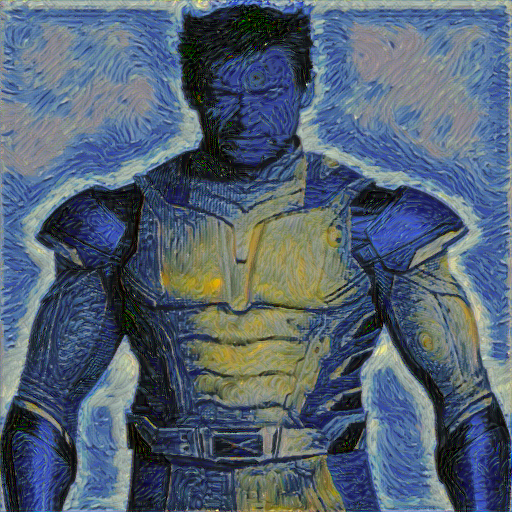

Optimizing: 100%|██████████| 7000/7000 [11:14<00:00, 10.38it/s, total_loss=4684.7905]   


In [9]:
from IPython.display import display, clear_output
from torchvision.utils import save_image
from PIL import Image

def denorm_imagenet(img_tensor):
    """Denormalize ImageNet normalized images for display"""
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(1, 3, 1, 1)
    return (img_tensor * std + mean).clamp(0, 1)

progress_bar = tqdm(range(7000), desc="Optimizing")
os.makedirs("./output", exist_ok=True)
preview_path = "./output/preview.png"

# Create initial preview
save_image(denorm_imagenet(x.detach()), preview_path)
img_handle = display(Image.open(preview_path), display_id=True)

for i in progress_bar:
    x_features = model(x)
    style_features = model(style)
    content_features = model(content)

    total_loss = calculate_loss(
        x_features, content_features, style_features
    )

    optimizer.zero_grad(set_to_none=True)
    total_loss.backward()
    optimizer.step()

    progress_bar.set_postfix(
        total_loss=f"{total_loss.item():.4f}"
    )    # Save every 200 steps
    if (i + 1) % 200 == 0:
        step = i + 1
        save_image(denorm_imagenet(x.detach()), f"./output/wolvi_{step}.png")

    # Show every 50 steps in notebook
    if (i + 1) % 50 == 0:
        save_image(denorm_imagenet(x.detach()), preview_path)
        img_handle.update(Image.open(preview_path))